In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os

from IPython.core.pylabtools import figsize
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

In [53]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [54]:
#load original data into dataframe
file ='train_clean.csv'
df = pd.read_csv(file)
df.shape

(7377415, 70)

In [55]:
df.drop('msno', axis=1, inplace = True)

df['isrc_year'] = df.isrc_year.apply(lambda x: x if x != 'year_missing' else -1)
df['isrc_year'] = df['isrc_year'].astype('int8')

#Converting to categories
cat_names = list(df.select_dtypes(include='object').columns)
df[cat_names] = df[cat_names].astype('category')
#df['language'] = df['language'].astype('category')

int_names = list(df.select_dtypes(include='int64').columns)
df[int_names] = df[int_names].astype('int32')

int_names_8 = ['composer_artist_lyricist', 'composer_artist']
df[int_names_8] = df[int_names_8].astype('uint8')


float_names = list(df.select_dtypes(include='float64').columns)
df[float_names] = df[float_names].astype('float32')

float_names = list(df.select_dtypes(include='float32').columns)
float_names.remove('song_length')
df[float_names] = df[float_names].astype('float16')

ua = ['usr_1', 'usr_2', 'usr_3'] #, 'song_freq', 'ua_1', 'ua_2', 'ua_3','ua_4','ua_5','ua_6','ua_7','ua_8','ua_9','ua_10']
df.drop(ua, axis=1, inplace = True)
#df.drop('artist_name_encoded', axis=1, inplace = True)

#df.info()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377415 entries, 0 to 7377414
Data columns (total 55 columns):
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int32
song_length                 float32
language                    float16
city                        int32
bd                          int32
gender                      category
registered_via              int32
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_year                   int8
duration                    int32
registration_year           int32
registration_month          int32
registration_day            int32
registration_weekday        int32
expiration_year             int32
expiration_month            int32
expiration_day              int32
expiration_weekday          int32
composer_artist_lyricist    uint8
composer_artist       

In [57]:
# Separating Numeric and Non_numeric Data
numeric = df.select_dtypes(exclude = 'category')
categorical = df.select_dtypes(include = 'category')

#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

In [58]:
#numeric.skew()

In [59]:
#Creating our Feature and Target Data Set: X, y respectively

X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = df.target

#Splitting Data into Training and Test Data Set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)


mean_length = X_train.song_length.mean()
X_train.song_length.fillna(mean_length, inplace = True)
X_test.song_length.fillna(mean_length, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [60]:
X_train['language'] = X_train['language'].astype('int16')
X_test['language'] = X_test['language'].astype('int16')

int_names = list(X_train.select_dtypes(include='int32').columns)
X_train[int_names] = X_train[int_names].astype('int16')
X_test[int_names] = X_test[int_names].astype('int16')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688707 entries, 1069668 to 6413414
Data columns (total 92 columns):
song_length                                float32
language                                   int16
city                                       int16
bd                                         int16
registered_via                             int16
lyricist_count                             int16
artist_count                               int16
composer_count                             int16
genre_count                                int16
isrc_year                                  int8
duration                                   int16
registration_year                          int16
registration_month                         int16
registration_day                           int16
registration_weekday                       int16
expiration_year                            int16
expiration_month                           int16
expiration_day                             int1

There are two types of error, False Positive and False Negative. Predicting that a patient will not get readmitted but actually patient gets readmitted. This is false negative. Predicting that a patient will get readmitted but in actually he will not os called false positive. For an hospital, a false negative error is not desirable. They can still live with a false positive error. So in below models we will look at reducing false negative error. 

High Recall for class 'Readmitted', Better the model


Ensuring that we have the same fractions of all class in both train and test data set. Let's Calculate the fraction

### Random Forest Classifier

In [62]:
# Base Line Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Listened', 'Listened']

In [63]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  7.6min


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 29.3min


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 30.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   50.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   53.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   47.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   50.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   47.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   50.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tas

Training accuracy: 0.7199


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   46.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   49.7s finished


Test accuracy    : 0.7054
Training AUC Score: 0.7995
Testing AUC Score: 0.7806
Classification Report - Training
              precision    recall  f1-score   support

           0       0.71      0.73      0.72   1832448
           1       0.73      0.71      0.72   1856259

    accuracy                           0.72   3688707
   macro avg       0.72      0.72      0.72   3688707
weighted avg       0.72      0.72      0.72   3688707

Classification Report - Testing
              precision    recall  f1-score   support

Not Listened       0.70      0.71      0.71   1830311
    Listened       0.71      0.70      0.70   1858397

    accuracy                           0.71   3688708
   macro avg       0.71      0.71      0.71   3688708
weighted avg       0.71      0.71      0.71   3688708



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   47.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   50.5s finished


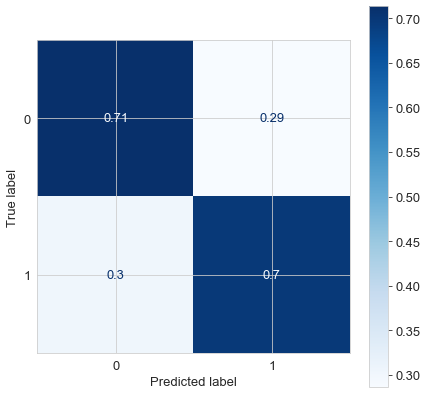

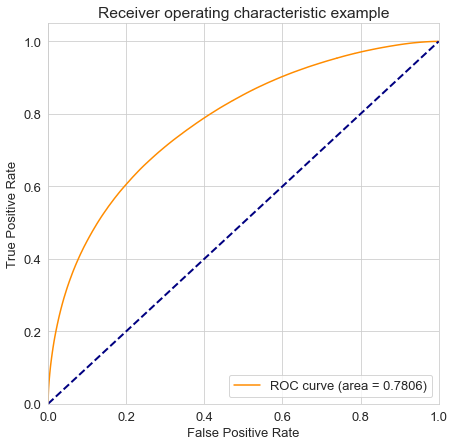

In [64]:
# Base Line Evaluation
rf = RandomForestClassifier(max_depth = 15, random_state = 42, n_jobs = 2, verbose = 4)

rf.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = rf.predict_proba(X_test)[:,1]
y_train_proba = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %rf.score(X_train, y_train))
print("Test accuracy    : %0.4f" %rf.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(rf, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688707 entries, 1069668 to 6413414
Columns: 102 entries, song_length to gender_male
dtypes: float16(37), float32(1), int16(19), int8(1), uint8(44)
memory usage: 594.5 MB


In [13]:
figsize(7,7)
import seaborn as sns
coefficients = rf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Feature Importance")
_ = sns.barplot(data = coef[:20], x = 'Feature Importance', y = coef[:20].index, orient = 'h')
#_ = plt.barh(coef[:20].index, coef['Feature Importance'][:20])

Top 20 Feature Importance


ValueError: Grouper and axis must be same length

In [18]:
def rf_classifier(X_train, X_test, n_trees):
    rf = RandomForestClassifier(n_jobs = 4, max_depth = n_trees, random_state = 42)

    rf.fit(X_train,y_train)

    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    
    y_test_proba = rf.predict_proba(X_test)[:,1]
    y_train_proba = rf.predict_proba(X_train)[:,1]


    #Accuracy Score
    auc_train = roc_auc_score(y_train,y_train_proba)
    auc_test = roc_auc_score(y_test,y_test_proba)
    #loss_train = log_loss(y_train, rf.predict_proba(X_train))
    #loss_test = log_loss(y_test, rf.predict_proba(X_test))
    
    return auc_train, auc_test
    #return loss_train, loss_test

### Hyper-parameter Tuning

In [19]:


n_trees = [20, 50, 100, 200, 500]
max_depths = [10, 15, 20, 25]
min_samples_split = [2, 10, 30,50, 75]
min_samples_leaf = [1, 2, 10, 35, 50, 75]
max_features = [4,5,6, 10, 15, 20]


train_auc = []
test_auc  = []

for i in max_depths:
    print(i)
    train, test = rf_classifier(X_train, X_test, i)
    train_auc.append(train)
    test_auc.append(test)

_ = plt.plot(max_depth, train_auc, 'r', label = 'Training')
_ = plt.plot(max_depth, test_auc, 'b', label = 'Test')
_ = plt.xlabel('Max_depth')
_ = plt.ylabel('AUC Score')


10


MemoryError: 

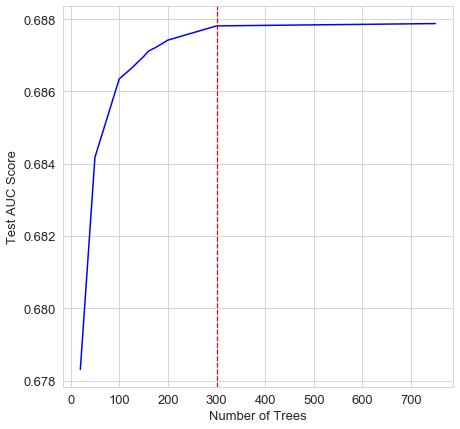

In [91]:
#_ = plt.plot(n_trees, train_auc, 'r', label = 'Training')
_ = plt.plot(n_trees, test_auc, 'b', label = 'Test')
_ = plt.xlabel('Number of Trees')
_ = plt.ylabel('Test AUC Score')
_ = plt.axvline(x = 300, color = 'r', linestyle = '--', linewidth = 1.25)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#n_trees = randint(100,150)
max_depths = randint(15,20)
min_samples_split = randint(20,100)
max_features = randint(15,30)

param_grid = {'max_depth': max_depths, 'min_samples_split': min_samples_split,
              'max_features':max_features } #'n_estimators':n_trees

rf = RandomForestClassifier(n_jobs = 4)

cv = RandomizedSearchCV(rf, param_distributions = param_grid, random_state=42, 
                        n_iter=150, cv=5, verbose=2, n_jobs=4, scoring = 'roc_auc')

cv.fit(X_train,y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 44.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 97.1min
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed: 107.5min finished


{'max_depth': 18, 'max_features': 15, 'min_samples_split': 27}
0.685164570688306


In [116]:
n_trees = [75, 100, 125, 150, 175, 200]
max_depths = [10, 12, 14, 15, 16, 20]
min_samples_split = [2, 30,50, 75, 100, 150]
min_samples_leaf = [2, 35, 50, 75, 100, 150]
max_features = np.arange(6,25,3)
print(max_features)

[ 6  9 12 15 18 21 24]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300

building tree 4 of 300

building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s


building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.5s


building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tas

Training accuracy: 0.7406


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


Test accuracy    : 0.6349
Training AUC Score: 0.8337
Testing AUC Score: 0.6878
Classification Report - Training
              precision    recall  f1-score   support

           0       0.72      0.84      0.78     37271
           1       0.78      0.63      0.69     32806

    accuracy                           0.74     70077
   macro avg       0.75      0.73      0.73     70077
weighted avg       0.75      0.74      0.74     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.63      0.74      0.68     15937
    Readmitted       0.64      0.52      0.57     14096

      accuracy                           0.63     30033
     macro avg       0.64      0.63      0.63     30033
  weighted avg       0.64      0.63      0.63     30033



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


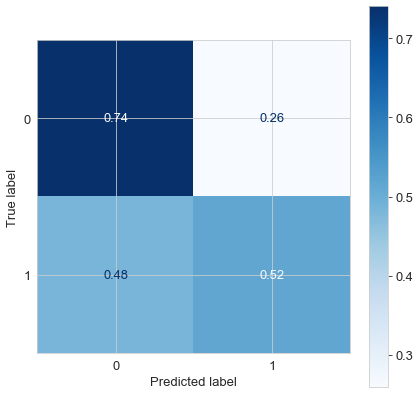

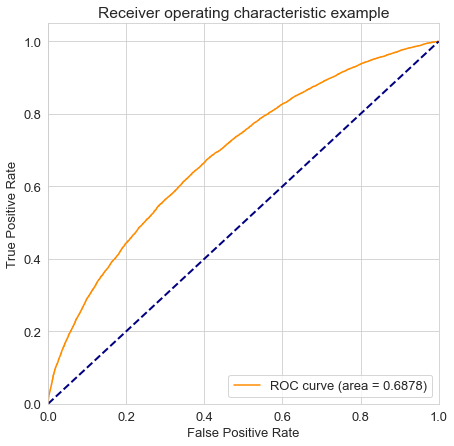

In [99]:
#best_lr = cv.best_estimator_

#best_lr.fit(X_train,y_train)

best_lr = RandomForestClassifier(n_jobs = 4, n_estimators = 300, max_features = 15,
                               max_depth = 18, min_samples_split = 27, random_state = 42, verbose = 2)
best_lr.fit(X_train, y_train)
#Predicting for testing and trainig data sets
y_test_proba = best_lr.predict_proba(X_test)[:,1]
y_train_proba = best_lr.predict_proba(X_train)[:,1]

y_pred_test = best_lr.predict(X_test)
y_pred_train = best_lr.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %best_lr.score(X_train, y_train))
print("Test accuracy    : %0.4f" %best_lr.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(best_lr, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 25 Feature Importance


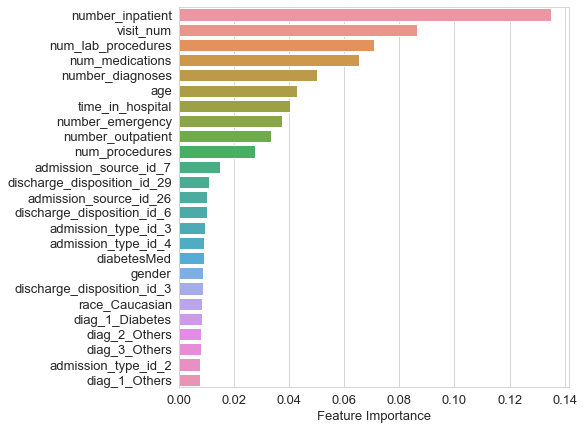

In [94]:
figsize(7,7)

coefficients = best_lr.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 25 Feature Importance")
_ = sns.barplot(data = coef[0:25], x = 'Feature Importance', y = coef[0:25].index, orient = 'h')
#_ = plt.barh(coef[:20].index, coef['Feature Importance'][:20])